In [326]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

# Rotary Positional Embeddings
https://nn.labml.ai/transformers/rope/index.html

- [paper](https://arxiv.org/pdf/2104.09864v5.pdf)

For 2 features x1 and x2 at position m from either key/query matrix, the transformation is:
$$
\begin{pmatrix}
x_m^{(1)} \\
x_m^{(2)}
\end{pmatrix}
\begin{pmatrix}
\cos(m \theta) & -\sin(m \theta) \\
\sin(m \theta) & \cos(m \theta)
\end{pmatrix}
=
\begin{pmatrix}
x_m^{(1)} \cos(m \theta) - x_m^{(2)} \sin(m \theta) \\
x_m^{(2)} \cos(m \theta) + x_m^{(1)} \sin(m \theta)
\end{pmatrix}
$$

> theta will change at every position for m positions

for 2 positions m,n, the dot product between their transformations applied with attention is the relative attention.

for i pairs of features, theta changes accordingly:

$$\theta_i = 10000^\frac{-2(i-1)}{d}, i \in \{0,1,2,3...,\frac{d}{2}\}$$

for feature $i$, we pair it with feature $i+\frac{d}{2}$

$$
\begin{pmatrix}
x_m^{(i)} & x_m^{(i+\frac{d}{2})}
\end{pmatrix}
\begin{pmatrix}
\cos(m \theta) & -\sin(m \theta) \\
\sin(m \theta) & \cos(m \theta)
\end{pmatrix}
=
\begin{pmatrix}
x_m^{(1)} \cos(m \theta) - x_m^{(i+\frac{d}{2})} \sin(m \theta) \\
x_m^{(i+\frac{d}{2})} \cos(m \theta) + x_m^{(1)} \sin(m \theta)
\end{pmatrix}
$$

### based on [MLX](https://github.com/ml-explore/mlx/blob/b0cd092b7f647044c4ed40bb40fa9d14bacc48f6/python/mlx/nn/layers/positional_encoding.py#L10)

In [327]:
class RoPE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dims = dim
        
    def create_cos_sin_theta(self, N, D, offset, base=10_000, dtype=torch.float32):
        D = D // 2
        positions = torch.arange(offset, N, dtype=dtype)
        freqs = torch.exp(-torch.arange(0.0, D, dtype=dtype) * (math.log(base) / D))
        theta = torch.reshape(positions, (-1, 1)) * torch.reshape(freqs, (1, -1))
        costheta = torch.cos(theta)
        sintheta = torch.sin(theta)

        return costheta, sintheta
    
    def _compute_rope(self, costheta, sintheta, x):
        x1 = x[..., ::2]
        x2 = x[..., 1::2]
        rx1 = x1 * costheta - x2 * sintheta
        rx2 = x1 * sintheta + x2 * costheta

        rx = torch.cat([rx1[..., None], rx2[..., None]], dim=-1)

        return rx
    
    def forward(self, x, offset=0):
        shape = x.shape
        x = torch.reshape(x, (-1, shape[-2], shape[-1]))
        N = x.shape[1] + offset
        
        costheta, sintheta = self.create_cos_sin_theta(
            N, self.dims, offset=offset, dtype=x.dtype
        )

        rx = self._compute_rope(costheta, sintheta, x)
        
        return torch.reshape(rx, shape)

In [328]:
# the dim should be the head_dim
rope_posembeds = RoPE(4096 // 16)

In [329]:
out = rope_posembeds(torch.rand(1,128,4096//16))
out.shape

torch.Size([1, 128, 256])

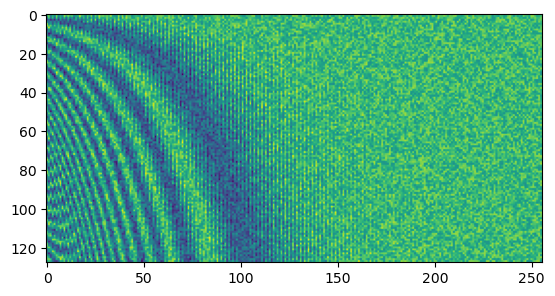

In [330]:
plt.imshow(out.squeeze())

## Based on [LiT-LLaMa](https://github.com/Lightning-AI/lit-llama/blob/main/lit_llama/model.py)

In [331]:
def create_rope_cache(head_size, seq_len, dtype=torch.float32, device='cpu'):
    
    theta = 1. / (10_000 ** (torch.arange(0, head_size, 2).float() / head_size)).to(device) # (dim//2,)
    seq = torch.arange(seq_len,dtype=dtype,device=device) # (seq_len,)
    
    theta_seq = torch.outer(seq,theta) # (seq_len, dim//2)
    
    cache = torch.stack([torch.sin(theta_seq), torch.cos(theta_seq)],dim=-1) # (seq_len, dim//2, 2)
    
    return cache

def apply_rope(x, rope_cache):
    B, T, nH, H = x.shape
    rope_cache = rope_cache[:T] # (T, H//2, 2)
    
    xshaped = x.float().reshape(B,T,nH,H//2,2) # B, T, nH, H//2, 2
    rope_cache = rope_cache.view(1, T, 1, H//2, 2) # 1, T, 1, H//2, 2
    
    # tensor[...,0]: get the 0 index elements from the last dim
    x_out = torch.stack([
        xshaped[...,0] * rope_cache[...,0] - xshaped[...,1] * rope_cache[...,1],
        xshaped[...,0] * rope_cache[...,1] + xshaped[...,1] * rope_cache[...,0] 
    ],-1) # B, T, nH, H//2, 2
    
    return x_out.flatten(3).to(dtype=x.dtype) # B, T, nH, H

In [332]:
x=torch.rand(1,128,4,64) # B x T x N_HEADS x HEAD_SIZE
rope_cache = create_rope_cache(256//4,128,torch.float32,'cpu')
x.shape, rope_cache.shape, apply_rope(x,rope_cache).shape

(torch.Size([1, 128, 4, 64]),
 torch.Size([128, 32, 2]),
 torch.Size([1, 128, 4, 64]))

## LabML implementation STEP BY STEP

- keeping it simple and applying rope to all dimensions of the embedding and not partial.
- modification to work with `(B,T,nH,H)`.

In [333]:
class RoPE(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        self.dim = head_dim
        self.seq_len_cache = None
        self.sin_cache = None
        self.cos_cache = None
        
    def _create_cache(self, x):
        """
        creates RoPE cache
        
        inputs:
            x: T, B, nH, H
        outputs:
            None
        """
        T = x.size(0)
        
        if self.seq_len_cache is None or T > self.seq_len_cache:
            self.seq_len_cache = T
            
        if self.cos_cache is not None and T < self.seq_len_cache:
            return
        
        i = torch.arange(0, self.dim, 2).float() / self.dim
        theta = 1.0 / (10000 ** i)
        theta.to(x.device)
        
        indices = torch.arange(T, device=x.device).float()
        
        freqs = torch.outer(indices, theta)
        
        freqs = torch.cat([freqs, freqs], dim=-1)
        
        self.sin_cache = freqs.sin()[:,None,None,:]
        self.cos_cache = freqs.cos()[:,None,None,:]
            
    def _rotate_half(self, x):
        
        half = self.dim // 2
        x1 = x[...,:half]
        x2 = x[...,half:]
        return torch.cat([-x2,x1],dim=-1)
    
    def forward(self, x):
        
        self._create_cache(x) # runs only if needed
        
        T = x.size(0)
        sin, cos = self.sin_cache[:T], self.cos_cache[:T]
        
        return x * cos + self._rotate_half(x) * sin

In [334]:
rope = RoPE(64)

In [335]:
x = torch.rand(128, 3, 4, 64) # T, B, nH, H

In [336]:
out = rope(x)

In [337]:
rope.seq_len_cache

128

In [338]:
rope.sin_cache.shape

torch.Size([128, 1, 1, 64])

In [339]:
rope.cos_cache.shape

torch.Size([128, 1, 1, 64])

In [340]:
x2 = torch.rand(64, 3, 4, 64)
out2 = rope(x2)
x2.shape

torch.Size([64, 3, 4, 64])

## Fairly good implementation using this moving forward;

- expected (B, T, nH, H) input shape
- doesn't support kv-cache, not sure?

In [341]:
class RoPE2(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        self.dim = head_dim
        self.seq_len_cache = None
        self.sin_cache = None
        self.cos_cache = None
        
    def _create_cache(self, x):
        """
        creates RoPE cache
        
        inputs:
            x: B, T, nH, H
        outputs:
            None
        """
        T = x.size(1)
        
        if self.seq_len_cache is None or T > self.seq_len_cache:
            self.seq_len_cache = T
            
        if self.cos_cache is not None and T < self.seq_len_cache:
            return
        
        i = torch.arange(0, self.dim, 2).float() / self.dim
        theta = 1.0 / (10000 ** i)
        theta.to(x.device)
        
        indices = torch.arange(T, device=x.device).float()
        
        freqs = torch.outer(indices,theta)
        
        freqs = torch.cat([freqs, freqs], dim=1)
        
        self.sin_cache = freqs.sin()[None,:,None,:]
        self.cos_cache = freqs.cos()[None,:,None,:]
            
    def _rotate_half(self, x):
        half = self.dim // 2
        x1 = x[...,:half]
        x2 = x[...,half:]
        return torch.cat([-x2,x1],dim=-1)
    
    def forward(self, x):
        
        B, T, nH, H = x.shape
        
        self._create_cache(x) # runs only if needed
        
        # T x H
        sin, cos = self.sin_cache[:,:T], self.cos_cache[:,:T]
        # B x T x 1 x H
        sin = sin.expand(B,-1,-1,-1)
        cos = cos.expand(B,-1,-1,-1)
        
        return (x * cos) + (self._rotate_half(x) * sin)

In [342]:
r2 = RoPE2(64)

In [343]:
x4 = torch.rand(3,128,4,64)
out4 = r2(x4)

In [344]:
out4.shape, r2.seq_len_cache, r2.sin_cache.shape, r2.cos_cache.shape

(torch.Size([3, 128, 4, 64]),
 128,
 torch.Size([1, 128, 1, 64]),
 torch.Size([1, 128, 1, 64]))

In [345]:
out.shape

torch.Size([128, 3, 4, 64])

In [346]:
torch.allclose(out.transpose(0,1),out4)

False

In [347]:
s1 = rope.sin_cache.squeeze()
s1.shape

torch.Size([128, 64])

In [348]:
s2 = r2.sin_cache.squeeze()
s2.shape

torch.Size([128, 64])

In [349]:
torch.allclose(s1,s2)

True

In [350]:
c1 = rope.cos_cache.squeeze()
c2 = r2.cos_cache.squeeze()
torch.allclose(c1,c2)

True

In [351]:
x = torch.rand(128,3,4,64)

In [352]:
rx1 = rope(x)
rx1.shape

torch.Size([128, 3, 4, 64])

In [353]:
x2 = x.transpose(0,1)
rx2 = r2(x2)
rx2.shape

torch.Size([3, 128, 4, 64])

In [354]:
torch.allclose(rx1.transpose(0,1),rx2)

True

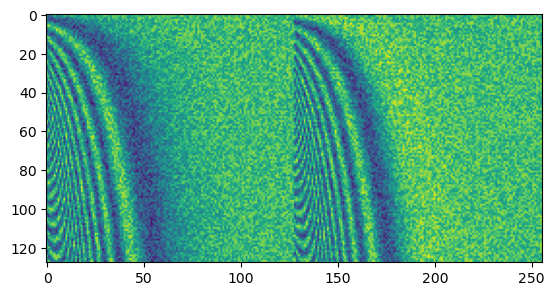

In [355]:
viz = RoPE2(4096//16)
x = torch.rand(1,128,1,4096//16) # 1 sample, 1 head
o = viz(x)
plt.imshow(o.squeeze())